<a href="https://colab.research.google.com/github/dspark0419/DATA-205/blob/main/Project_Stat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import/Upgrade Libraries**

In [ ]:
!python --version

Python 3.7.10


In [ ]:
# hide outputs
%%capture
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade matplotlib
!pip install --upgrade seaborn
!pip install --upgrade scipy
!pip install --upgrade math

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import random
from math import sqrt

# **MC Census Data: mcPop**

In [ ]:
mcPop = pd.read_csv('mcPop.csv')
mcPop.head()

,Unnamed: 0,Zip Code,AREALAND,AREAWATR,Population,HU100,NH White,NH Black,NH American Indian,NH Asian,NH Native Hawaiian,NH Other,NHT,Hispanic,PNHW,PNHB,PNHAI,PNHA,PNHNH,PNHO,PNHT,PHISP,Pop 65+,PCTPOP65_,Shape_Area
0,62,20707,28896187,481328,31538,13576,9599,13425,72,2849,15,111,796,4671,30.4,42.6,0.2,9.0,0.0,0.4,2.5,14.8,2998,9.5,4.827461e+07
1,102,20777,19568844,110664,3314,1111,2692,155,10,274,2,2,79,100,81.2,4.7,0.3,8.3,0.1,0.1,2.4,3.0,428,12.9,3.274726e+07
2,111,20812,496734,371058,255,100,230,3,0,6,0,0,6,10,90.2,1.2,0.0,2.4,0.0,0.0,2.4,3.9,33,12.9,1.437529e+06
3,112,20814,13166146,52953,27642,14103,21021,1134,34,2572,20,74,695,2092,76.0,4.1,0.1,9.3,0.1,0.3,2.5,7.6,4508,16.3,2.192136e+07
4,113,20815,14066048,35097,29082,13850,23357,1256,28,1804,13,90,702,1832,80.3,4.3,0.1,6.2,0.0,0.3,2.4,6.3,6002,20.6,2.337013e+07


Drop unnamed columns

In [ ]:
mcPop = mcPop.loc[:, ~mcPop.columns.str.contains('^Unnamed')]

In [ ]:
std_zip = mcPop['Zip Code'].unique()

# **MC Real Property Tax Data: mcTax**

In [ ]:
mcTax = pd.read_csv('mcTax.csv')
mcTax.head()

,Unnamed: 0,Zip Code,RESIDENCE,ASSESSMENT,COUNTY PROPERTY TAX,COUNTY PROPERTY TAX Percent
0,35,20872,PRINCIPAL RESIDENCE,499833,4954.35,0.991201
1,40,20872,PRINCIPAL RESIDENCE,404467,4009.08,0.991201
2,47,20906,NOT A PRINCIPAL RESIDENCE,339000,3360.16,0.991198
3,52,20902,PRINCIPAL RESIDENCE,405467,4018.97,0.991195
4,56,20902,PRINCIPAL RESIDENCE,359633,3564.69,0.991202


In [ ]:
mcTax = mcTax.loc[:, ~mcTax.columns.str.contains('^Unnamed')]

# **MC Crime Data: mcCrime**

In [ ]:
mcCrime = pd.read_csv('mcCrime.csv')
mcCrime.head()

,Unnamed: 0,Victims,Crime Name1,Crime Name2,Crime Name3,Zip Code,Start_Date_Time,Year
0,0,1,Crime Against Property,Burglary/Breaking and Entering,BURGLARY - NO FORCED ENTRY-RESIDENTIAL,20816,03/18/2020 09:00:00 PM,2020
1,1,1,Other,All Other Offenses,POLICE INFORMATION,20872,03/19/2020 01:00:00 PM,2020
2,2,1,Crime Against Property,Shoplifting,LARCENY - SHOPLIFTING,20876,08/19/2020 06:30:00 PM,2020
3,3,1,Crime Against Property,Embezzlement,EMBEZZLE (DESCRIBE OFFENSE),20860,11/02/2018 03:34:00 PM,2018
4,4,1,Crime Against Society,All Other Offenses,SEX OFFENSE - FAILURE TO REGISTER AS A SEX OFF...,20878,11/02/2018 12:00:00 AM,2018


In [ ]:
mcCrime = mcCrime.loc[:, ~mcCrime.columns.str.contains('^Unnamed')]

# **Statistical Analysis**

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6) # global fugure size

## **Confidence Interval and t-Test for Mean mcTax**

Obtain the statistical description of the county property tax.

In [ ]:
mcTax['COUNTY PROPERTY TAX'].describe()

count    3.139900e+05
mean     5.906543e+03
std      2.601276e+04
min      8.800000e-01
25%      2.728460e+03
50%      3.966790e+03
75%      6.030425e+03
max      4.833150e+06
Name: COUNTY PROPERTY TAX, dtype: float64

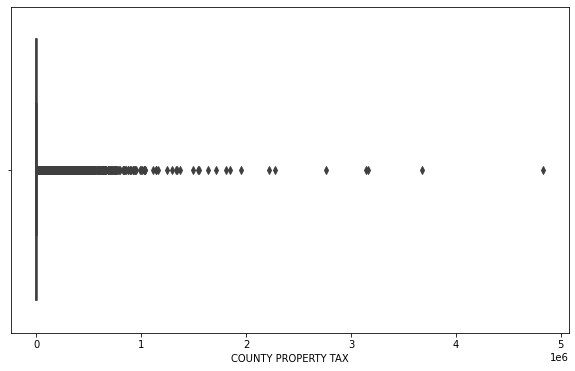

In [ ]:
sns.boxplot(x=mcTax['COUNTY PROPERTY TAX'])
plt.show()

The data is NOT normally distributed and is heavily skewed to the right.  
Find the 95% interval in the middle of the data.

In [ ]:
np.percentile(mcTax['COUNTY PROPERTY TAX'], [2.5, 97.5])

array([  148.68  , 15797.2715])

Sample the data and compute the sample mean of the county property tax.

In [ ]:
mcTax_sample = mcTax.sample(n=1000, random_state=123)
tax_sample = mcTax_sample['COUNTY PROPERTY TAX']
sample_mean = tax_sample.mean()
sample_mean

6744.42256

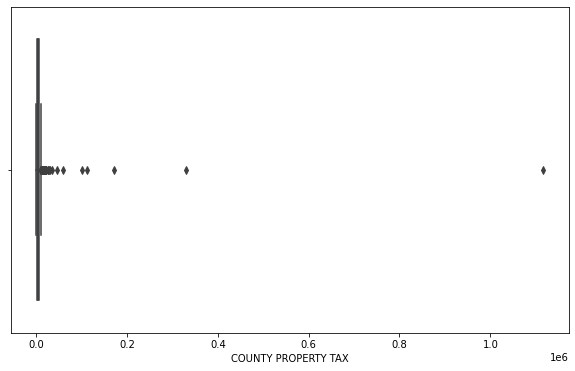

In [ ]:
sns.boxplot(x=tax_sample)
plt.show()

The distribution for the county property tax is heavily skewed to the right. But a t-test is robust to normality.  
Construct a 95% confidence interval for the mean county property tax using a t-distribution.

In [ ]:
stats.t.interval(0.95, df=len(tax_sample)-1, loc=np.mean(tax_sample), scale=stats.sem(tax_sample))

(4417.1083592895175, 9071.736760710482)

We are 95% sure that the mean county property tax is between 4417.1 and 9071.7. Since the true mean county property tax is 5906.5 that is contained in the CI, we mostly expect that p-values in two-tailed hypothesis tests should be greater than 0.05 not to reject the null hypothesis.

In [ ]:
sample_mean, np.mean(mcTax['COUNTY PROPERTY TAX'])

(6744.42256, 5906.54275776238)

Conduct a right-tailed hypothesis test for the mean county property tax.

In [ ]:
stats.ttest_1samp(tax_sample, np.mean(mcTax['COUNTY PROPERTY TAX']), alternative='greater')

Ttest_1sampResult(statistic=0.706482294000198, pvalue=0.24002649756712485)

Since p-value is 0.24, we must not reject the null hypothesis. There is not enough evidence that the mean county property tax is higher than 5906.5, the true mean county property tax.

## **Confidence Interval and 2-Sample t-Test for means of victims per 1000 residents based on Pop 65+**

Merge two datasets mcPop and mcCrime.  
Create a column for the numbers of victims per 1000 residents.

In [ ]:
mcPopCrime = mcPop.merge(mcCrime, on='Zip Code')
mcPopCrime['Victims_per_1000Residents'] = mcPopCrime['Victims'] / mcPopCrime['Population'] * 1000

Visualize the number of victims per 1000 residents and the percent of age 65 or older for any relationship.

In [ ]:
summaries = {'Victims_per_1000Residents': 'sum', 'PCTPOP65_': 'mean'}
mcPopCrime_byZip = mcPopCrime.groupby('Zip Code').agg(summaries).reset_index()

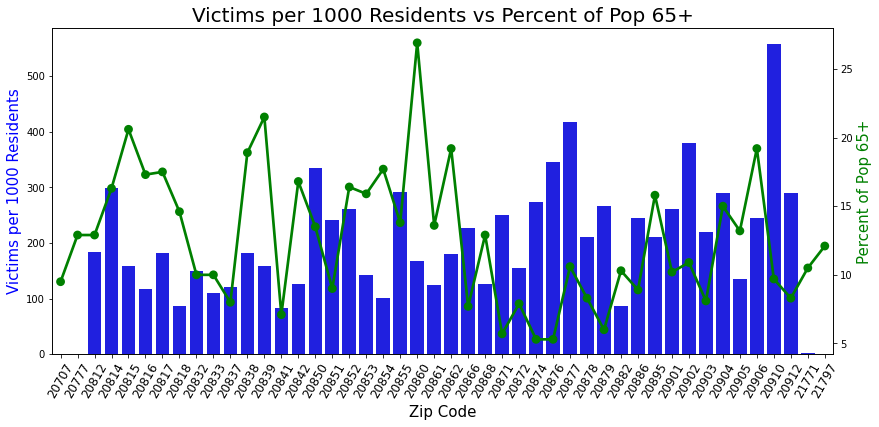

In [ ]:
fig, ax = plt.subplots(figsize=[14,6])

sns.barplot(ax=ax, data=mcPopCrime_byZip, x='Zip Code', y='Victims_per_1000Residents',
              color='blue', ci=None, estimator=sum)
ax1 = ax.twinx()
sns.pointplot(ax=ax1, data=mcPopCrime_byZip, x='Zip Code', y='PCTPOP65_', color='green',
              ci=None, estimator=sum)

ax.set_title('Victims per 1000 Residents vs Percent of Pop 65+', size=20)
#ax.set_xticks()
ax.set_xticklabels(mcPopCrime_byZip['Zip Code'].unique(), rotation=60, size=12) #ax.get_xticklabels()
ax.set_xlabel('Zip Code', size=15)
ax.set_ylabel('Victims per 1000 Residents', size=15, color='blue')
ax1.set_ylabel('Percent of Pop 65+', size=15, color='green')

plt.show()

It seems that they are approximately inverse-proportional. To confirm this observation, will conduct a 2-sample t-test and construct a 95% confidence interval.

Compute the mean percent of age 65 or older.

In [ ]:
mean_percent_65up = mcPopCrime['PCTPOP65_'].mean()
mean_percent_65up

11.740988190550349

Divide the data into two datasets: percent of age 65 or older >= mean percent and percent of age 65 or older < mean percent.

In [ ]:
mcPopCrime_PopUp = mcPopCrime[mcPopCrime['PCTPOP65_'] >= mean_percent_65up]
mcPopCrime_PopDown = mcPopCrime[mcPopCrime['PCTPOP65_'] < mean_percent_65up]

Sample each dataset.

In [ ]:
mcPopCrime_PopUp_sample = mcPopCrime_PopUp.sample(n=1000, random_state=123)
mcPopCrime_PopDown_sample = mcPopCrime_PopDown.sample(n=1000, random_state=123)

Group each dataset by Zip Codes.

In [ ]:
summaries = {'Victims_per_1000Residents': 'sum', 'Population': 'mean'}
mcPopCrime_PopUp_sample_byZip = mcPopCrime_PopUp_sample.groupby('Zip Code').agg(summaries).reset_index()
mcPopCrime_PopDown_sample_byZip = mcPopCrime_PopDown_sample.groupby('Zip Code').agg(summaries).reset_index()

In [ ]:
mcPopCrime_PopUp_sample_byZip.shape, mcPopCrime_PopDown_sample_byZip.shape

((19, 3), (21, 3))

Check the distributions and variances.

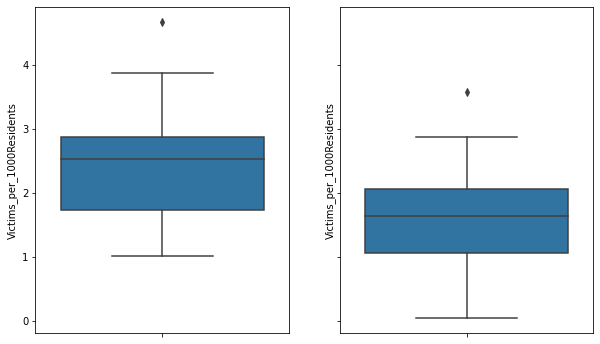

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True)
sns.boxplot(ax=ax[0], data=mcPopCrime_PopUp_sample_byZip, y='Victims_per_1000Residents')
sns.boxplot(ax=ax[1], data=mcPopCrime_PopDown_sample_byZip, y='Victims_per_1000Residents')
plt.show()

The sample sizes of the two datasets are less than 30. But their distributions are approximately normal and have roughly equal variances. So, use t-distributions for tests and confidence intervals.

Conduct a 2-sample t-test for the difference of means.

In [ ]:
stats.ttest_ind(mcPopCrime_PopUp_sample_byZip['Victims_per_1000Residents'],
                mcPopCrime_PopDown_sample_byZip['Victims_per_1000Residents'], alternative='greater')

Ttest_indResult(statistic=2.870025771875396, pvalue=0.003335324446386881)

Since p-value is very small, reject the null hypothesis. So, there is very strong evidence that the zip codes where the percent of age 65 or older is >= the mean percent of age 65 or older have more victims per 1000 residents than the other.

Construct a 95% confidence interval for the mean difference of the numbers of victims per 1000 residents.

In [ ]:
N1 = len(mcPopCrime_PopUp_sample_byZip)
N2 = len(mcPopCrime_PopDown_sample_byZip)
df = np.min([N1-1, N2-1])
mean1 = mcPopCrime_PopUp_sample_byZip['Victims_per_1000Residents'].mean()
mean2 = mcPopCrime_PopDown_sample_byZip['Victims_per_1000Residents'].mean()
std1 = mcPopCrime_PopUp_sample_byZip['Victims_per_1000Residents'].std()
std2 = mcPopCrime_PopDown_sample_byZip['Victims_per_1000Residents'].std()

sample_stat = mean1 - mean2
SE = sqrt((std1)**2 / N1 + (std2)**2 / N2)
ME = stats.t.ppf(0.975, df) * SE

print ('95% CI: ({:2.5f}, {:2.5f})'.format(sample_stat - ME, sample_stat + ME))

95% CI: (0.22226, 1.46254)


The confidence interval contains only positive numbers. Thus, we can conclude the same as the t-test.

## **Chi-square Test**  
Is there evidence that the population of age 65 or older is associated with the amount of the county property tax?

Merge two datasets mcPop and mcTax.

In [ ]:
mcPopTax = mcPop.merge(mcTax, on='Zip Code')

Create a categorical column for the county property tax by Up/Down from the average tax.

In [ ]:
Avg_Tax = mcPopTax['COUNTY PROPERTY TAX'].mean()
mcPopTax['Avgerage Tax UpDown'] = pd.cut(mcPopTax['COUNTY PROPERTY TAX'], bins=[-1, Avg_Tax -0.01, np.inf],
                                         labels=['down', 'up'])

Create a categorical column for the percent of age 65 or older by Up/Down from the average percent.

In [ ]:
mcPopTax['Mean PCT_65up UpDown'] = pd.cut(mcPopTax['PCTPOP65_'], bins=[-1, mean_percent_65up -0.01, np.inf],
                                          labels=['down', 'up'])

Create a frequency table for the two columns.

In [ ]:
table_tax_65 = pd.crosstab(mcPopTax['Avgerage Tax UpDown'], mcPopTax['Mean PCT_65up UpDown'], margins=True)
table_tax_65

Mean PCT_65up UpDown,down,up,All
Avgerage Tax UpDown,,,
down,137294,94864,232158
up,19140,62692,81832
All,156434,157556,313990


Conduct a chi-square test.

In [ ]:
stats.chi2_contingency(table_tax_65)

(30929.951078373335,
 0.0,
 4,
 array([[115664.20768814, 116493.79231186, 232158.        ],
        [ 40769.79231186,  41062.20768814,  81832.        ],
        [156434.        , 157556.        , 313990.        ]]))

Every expected cell count is big, so the chi-square distribution is appropriate. Since p-value is 0, reject the null hypothesis. Thus, there is very strong evidence that the population of age 65 or older is associated with the amount of the county property tax.